This notebook explores how to calculate the area within the zero isotherm - that is, the area of the Cold Intermediate Layer.

Will explore regridding to very high resolution.

In [1]:
import geopy.distance
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import shapely
from shapely.geometry.polygon import Polygon

import scipy.interpolate as interp

%matplotlib inline

# Load data

In [2]:
#coordinates of seal island transect
stations = pd.read_table('sealisland.txt', delimiter=' ')
numstations=stations.shape[0]
# distance along transect in km
distance = [geopy.distance.distance((stations.iloc[0]['LAT'], stations.iloc[0]['LON']),
                                    (stations.iloc[i]['LAT'], stations.iloc[i]['LON'])).km for i in range(numstations)]

In [3]:
# Read PSY4 data along SealIsland - I already saved in a csv
d = pd.read_csv('SealIsland_2020_global-analysis-forecast-phy-001-024.csv')

In [4]:
# Create arrays
temp = d['Temperature [degrees_C]'].values
depths = d['Depth [m]'].values
size=len(temp)
# Reshape data
numdepths = int(size/numstations)
temp = temp.reshape((numstations, numdepths ))
temp = np.ma.masked_invalid(temp)
depths = depths.reshape((numstations, numdepths))
_, distance = np.meshgrid(depths[0, :], distance)
mask = temp.mask
mask = mask*1

# Plotting

/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: No contour levels were found within the data range.
  """


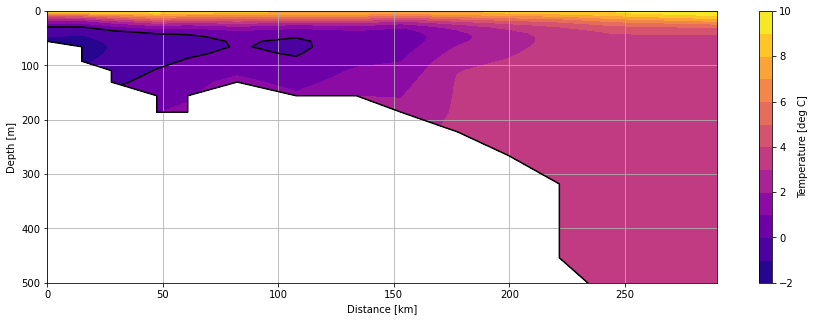

In [5]:
#Quick plot
fig, ax = plt.subplots(1,1,figsize=(15,5))
mesh = ax.contourf(distance, depths, temp, cmap='plasma',levels=np.arange(-2, 11,1))
contour = ax.contour(distance, depths, temp, [0,], colors='k')
cmask = ax.contour(distance, depths, mask, [1,], colors='k')
cbar = plt.colorbar(mesh,ax=ax)
cbar.set_label('Temperature [deg C]')
ax.set_ylim([500,0])
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Distance [km]')
ax.grid()

# Regridding
Try to interpoolate to successfully higher resolutions to see if area gets closer to the contour method.

In [6]:
def regrid(xo, yo, tempo, nx=100, ny=100, depthmax=700):
    xnew = np.linspace(xo[0,0],xo[-1,0], num=nx )
    ynew = np.linspace(yo[0,0],depthmax, num=ny )
    yy,xx = np.meshgrid(ynew, xnew)
    tempnew = interp.griddata((xo.flatten(),yo.flatten()),temp.flatten(), (xx,yy))
    tempnew = np.ma.masked_invalid(tempnew)
    return xx, yy, tempnew

In [7]:
def plot_transect(x,y,t,ax):
    ax.pcolormesh(x,y,t,cmap='plasma',vmin=-2,vmax=10)
    contour = ax.contour(distance, depths, temp, [0,], colors='k')
    cmask = ax.contour(distance, depths, mask, [1,], colors='k')
    cbar = plt.colorbar(mesh,ax=ax)
    cbar.set_label('Temperature [deg C]')
    ax.set_ylim([500,0])
    ax.set_ylabel('Depth [m]')
    ax.set_xlabel('Distance [km]')
    ax.grid()

In [8]:
def calculate_area(x,y,temp):
    below_zero = np.ma.masked_greater(temp, 0)
    diffs_x = np.diff(x, axis=0)
    diffs_y = np.diff(y, axis=1)
    area = np.nansum(diffs_x[:, :-1]*diffs_y[:-1, :]/1000*(1-below_zero.mask[:-1,:-1]))
    return area

/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: No contour levels were found within the data range.
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'Interpolated (100x100)')

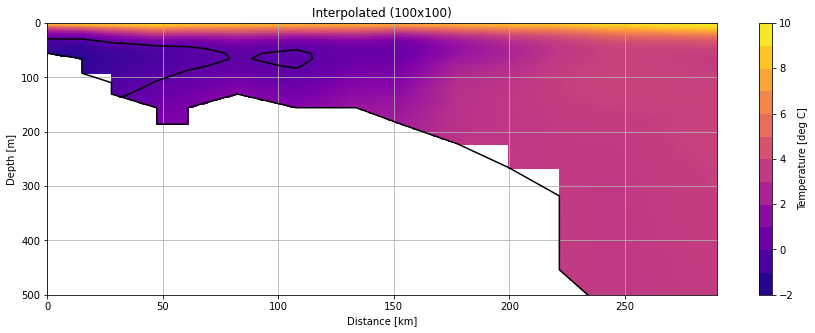

In [9]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
xx,yy,tempn = regrid(distance, depths, temp, nx=500,ny=500)
plot_transect(xx,yy,tempn,ax)
ax.set_title('Interpolated (100x100)')

In [10]:
area=calculate_area(xx,yy,tempn)
print('Interpolated (100x100) Area: \t', area)
area = calculate_area(distance,depths,temp)
print('Original data Area: \t', area)

Interpolated (100x100) Area: 	 4.706150208931988
Original data Area: 	 6.591162611007409


# Loop through many regriddings

Contour method area 4.807365629409965
Original area: 6.591162611007409
Interpolated (50x50) area: 4.813065069912741
Interpolated (100x100) area: 4.550837510725379
Interpolated (200x200) area: 4.663921818001187


/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: No contour levels were found within the data range.
  after removing the cwd from sys.path.


Interpolated (300x300) area: 4.701061827229413
Interpolated (400x400) area: 4.68769194081359
Interpolated (500x500) area: 4.706150208931988


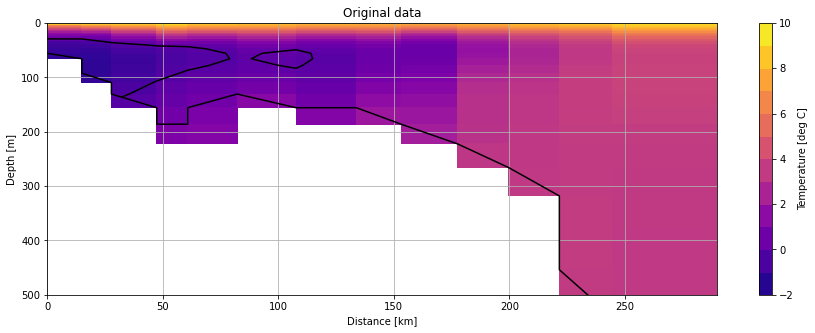

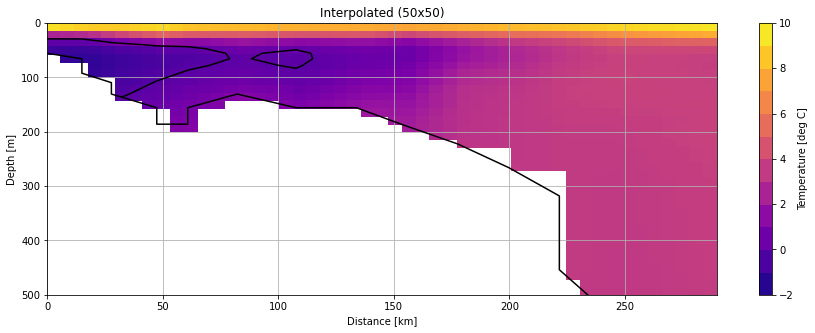

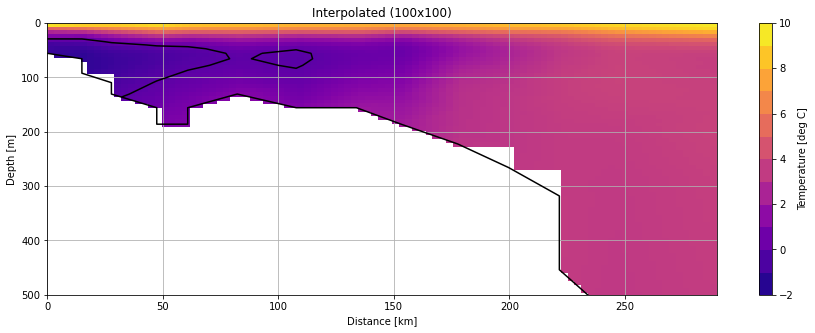

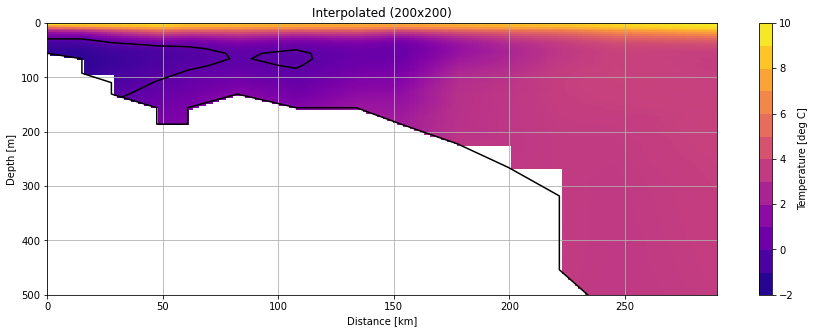

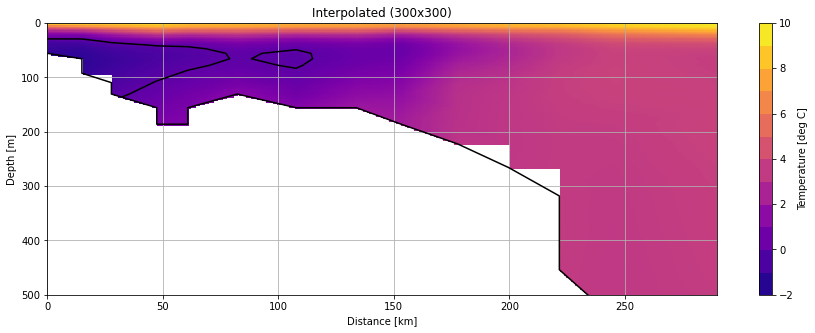

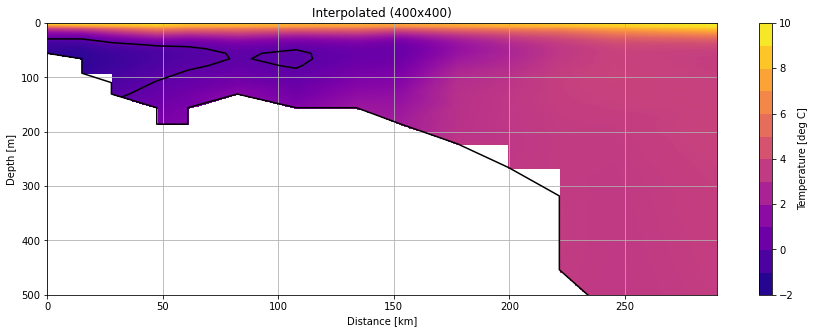

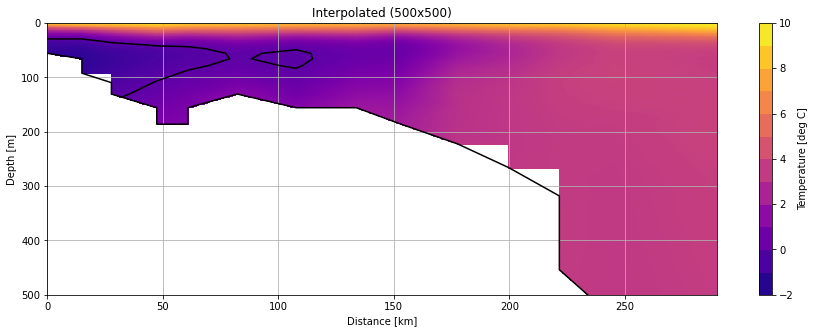

In [11]:
nxs = [50,100,200,300, 400, 500]
nys = [50,100,200,300, 400, 500]
contour_area = 4.807365629409965
print('Contour method area {}'.format(contour_area))
fig, ax = plt.subplots(1,1,figsize=(15,5))
ax.set_title('Original data')
area = calculate_area(distance,depths,temp)
print('Original area: {}'.format(area))
plot_transect(distance,depths,temp,ax)
for nx, ny in zip(nxs,nys):
    fig, ax = plt.subplots(1,1,figsize=(15,5))
    xx,yy,tempn = regrid(distance, depths, temp, nx=nx,ny=ny)
    plot_transect(xx,yy,tempn,ax)
    ax.set_title('Interpolated ({}x{})'.format(nx,ny))
    area = calculate_area(xx,yy,tempn)
    print('Interpolated ({}x{}) area: {}'.format(nx,ny,area))

# Take away
Regridding is an improvement over working with the orginal data but there are still some discrepancies with the contour methods. 

Am I handling the masking incorrectly? Some "corners" aren't being filled as I would expect.